# Title
    
*ZhuravlevAG_01_Sales_analiz.ipynb*

## Purpose
Спрогнозировать продажи по каждому товару на три месяца вперед.
Найти оптимальную цену товара, максимизирующую выручку.

## Methodology
Из-за большого числа категориальных признаков использую CatBoost. Это позволяет не делать OneHotEncoder

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1 Можно раздилить товары с высокой и низкой сезонной вариативностью (делить по CV) и построить модели для каждой группы;
- todo 2 Сделать PCA для покупателей, посмотреть на результат модели.
- todo 3 Отнормировать (город, тип покупателя) покупателей для корректного расчета.

## Results
1. Построена модель. Точность по метрике SMAPE = 4,02%.
2. Сделано предсказание по товарам на три месяца вперед.
3. Проанализирована выручка в зависимости от цены товара по группам производителей.

## Suggested next steps
Необходимо увеличить детализацию данных как по годам, так и по агрегации (с месяца на декады месяца)

# Setup

## Library import
We import all the required Python libraries

In [1]:
# Support
import datetime
import pickle
from tqdm import tqdm

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100 # я не использую head, т.к. он дает мало информации о фрейме. Обычно я просто весь фрейм проглядываю глазами

# Visualizations
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)


import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

import matplotlib.pyplot as plt
# models
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# scores
from sklearn.metrics import f1_score, accuracy_score,r2_score, roc_auc_score, recall_score

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2
print(f'Import Libs at {datetime.datetime.now()}')

Import Libs at 2021-11-20 19:56:25.007932


## Local library import
We import all the required local libraries libraries

In [2]:
# Include local library paths
import sys
import os
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
FINISH_DATE = '2019-06-01' # определяем дату конца обучающего датасеета


# Data import
We retrieve all the required data for the analysis.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              1729 non-null   int64  
 1   month             1729 non-null   int64  
 2   location          1729 non-null   object 
 3   ira               1729 non-null   object 
 4   product_category  1729 non-null   object 
 5   brand             1729 non-null   object 
 6   sku_id            1729 non-null   object 
 7   item_per_bundle   1729 non-null   int64  
 8   shape             1729 non-null   object 
 9   with_alcohol      1729 non-null   object 
 10  filling           1729 non-null   object 
 11  volume            1729 non-null   float64
 12  price             1617 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 175.7+ KB
None


<AxesSubplot:>

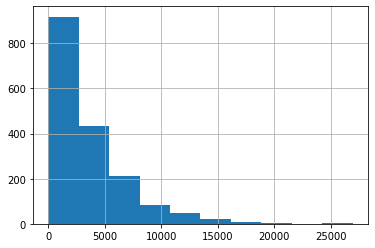

In [4]:
# импорт по продажам
df_sales_raw = pd.read_csv(r"..\data\sales.tsv", sep = '\t')
print(df_sales_raw.info())
df_sales_raw.volume.hist()

In [5]:
# импорт по пользователям
df_client_raw = pd.read_csv(r"C:\work\VB\sales\data\customers.tsv", sep = '\t')
print(df_client_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 1980 non-null   int64  
 1   month                1980 non-null   int64  
 2   ira                  1980 non-null   object 
 3   customers_type       1980 non-null   object 
 4   amount_of_customers  1980 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 77.5+ KB
None


# Data processing


### First analisis

In [6]:
"""
Структурирую данные по продажам
1. Нужно получить дату, с ней потом легче работать. Ставлю первое число соответствующего месяца
2. Необходимо нормировать продажи для каждого наименования и города, чтобы строить модель на изменениях, 
а абсолютные значения восстановим из нормы
3. Нормируем цену товара на один юнит, т.к. покупку пачкой трудно сравнивать с покупкой юнита
"""
df_sales = df_sales_raw.copy()
df_sales['date'] = pd.to_datetime({'year':df_sales.year,
                                  'month':df_sales.month,
                                  'day':1})
df_mean_sales = df_sales.groupby(['sku_id', 'ira'], as_index=False). \
                        agg({'volume':'mean', 'date':'nunique'}). \
                        rename(columns={'volume':'volume_mean', 'date':'count_val'}) # calculate mean volume and unique value

print(f'{df_mean_sales.shape = }')
df_std_sales = df_sales.groupby(['sku_id', 'ira'], as_index=False). \
                        agg({'volume':'std'}). \
                        rename(columns={'volume':'volume_std'})
print(f'{df_std_sales.shape = }')

#df_sales.price.fillna(df_sales.price_mean, inplace=True)
df_sales['price_norm'] = df_sales.price / df_sales.item_per_bundle # norm price for one unite
price_end = df_sales[['price_norm', 'sku_id', 'ira']][df_sales.date == FINISH_DATE]. \
                    rename(columns={'price_norm': 'price_finish'})# deternined finish price and norm them

df_sales = df_sales.merge(df_mean_sales, on=['sku_id', 'ira']).\
                    merge(df_std_sales, on=['sku_id', 'ira']). \
                    merge(price_end, on=['sku_id', 'ira'])

df_sales['volume_norm'] = (df_sales['volume'] - df_sales['volume_mean']) / df_sales['volume_std']

df_sales.dropna(inplace=True) # delete sku 60 in PB, one value
df_sales.drop(['year', 'month'], axis=1, inplace=True) # сейчас уже не нужны.
df_sales.isna().sum()


df_mean_sales.shape = (87, 4)
df_std_sales.shape = (87, 3)


location            0
ira                 0
product_category    0
brand               0
sku_id              0
item_per_bundle     0
shape               0
with_alcohol        0
filling             0
volume              0
price               0
date                0
price_norm          0
volume_mean         0
count_val           0
volume_std          0
price_finish        0
volume_norm         0
dtype: int64

In [7]:
"""
Поскольку основным городом продаж является АС, то из расмотрения следует убрать товары,
которые продавались в этом городе не достаточное время.
Видно, что для большей части данные по продажам полные. Оставим только эти данные.
"""
print(df_sales[df_sales.ira == 'AC'].sku_id.value_counts())
sku = ['sku #48', 'sku #38', 'sku #73', 'sku #25', 'sku #49', 'sku #15',
       'sku #46', 'sku #41', 'sku #31', 'sku #30', 'sku #28', 'sku #22',
       'sku #16','sku #77', 'sku #76']
df_sales = df_sales[df_sales.sku_id.isin(sku)]
print(df_sales.describe())

sku #48     30
sku #38     30
sku #73     30
sku #25     30
sku #49     30
sku #15     30
sku #46     30
sku #41     30
sku #31     30
sku #30     30
sku #28     30
sku #22     30
sku #16     30
sku #77     22
sku #76     22
sku #94     18
sku #97     18
sku #79     18
sku #106    18
sku #78     18
sku #100    18
Name: sku_id, dtype: int64
       item_per_bundle        volume       price  price_norm   volume_mean  \
count       999.000000    999.000000  999.000000  999.000000    999.000000   
mean          1.439439   4561.509510    1.727629    1.241280   4561.509510   
std           0.734278   3703.801454    0.729956    0.101177   3362.126084   
min           1.000000     49.000000    1.163406    0.955467     66.166667   
25%           1.000000   1932.000000    1.257571    1.187018   2208.800000   
50%           1.000000   3582.000000    1.298127    1.256294   3774.400000   
75%           2.000000   6081.000000    2.245000    1.291007   6456.000000   
max           3.000000  26952.0000


На примере видно, что в разных городах уровень продаж отличается в тысячу раз. 
Нормированные продажи при этом ведут себя очень похоже.
1. Есть четко выделенная сезонность. Будет учтена месяцем и пользователями.
Для некоторых товаров сезонности не наблюдается, продажи слабовариативны.
2. Нет ярко выраженного тренда на увеличение или уменьшение. Возможно, узкий период данных для наблюдения тренда.
3. В случае города PB, где продажи очень маленькие, мы видим сильный шум. 
Скореее всего это дробовой шум, который мы не сможем воспроизвести моделью.
Величина этого шума равна корень из продаж.




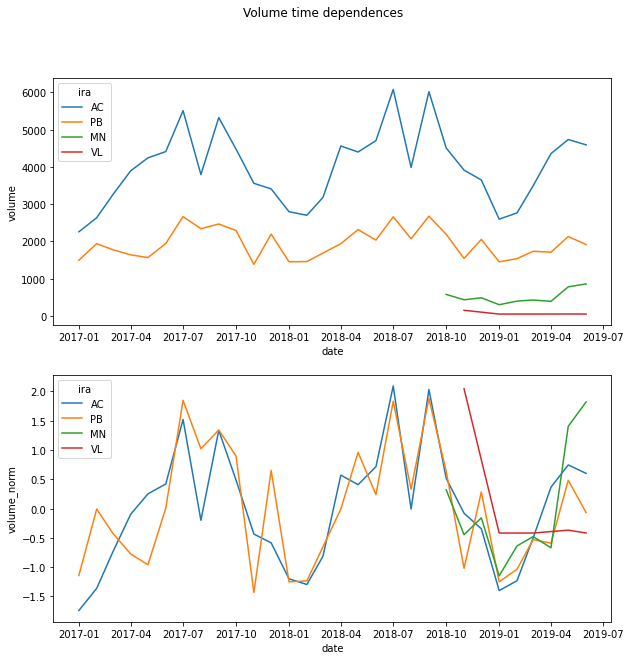

In [8]:
fig, ax = plt.subplots(2, figsize=(10,10))
fig.suptitle('Volume time dependences')
sns.lineplot(data=df_sales[df_sales.sku_id=='sku #73'], x='date', y=df_sales.volume, hue='ira', ax=ax[0])
sns.lineplot(data=df_sales[df_sales.sku_id=='sku #73'], x='date', y=df_sales.volume_norm, hue='ira', ax=ax[1])
print(
"""
На примере видно, что в разных городах уровень продаж отличается в тысячу раз. 
Нормированные продажи при этом ведут себя очень похоже.
1. Есть четко выделенная сезонность. Будет учтена месяцем и пользователями.
Для некоторых товаров сезонности не наблюдается, продажи слабовариативны.
2. Нет ярко выраженного тренда на увеличение или уменьшение. Возможно, узкий период данных для наблюдения тренда.
3. В случае города PB, где продажи очень маленькие, мы видим сильный шум. 
Скореее всего это дробовой шум, который мы не сможем воспроизвести моделью.
Величина этого шума равна корень из продаж.

""")
# TODO Можно раздилить товары с высокой и низкой сезонной вариативностью (делить по CV) и построить модели для каждой группы
# На данном этапе данных мало, результат отрицательный.


В целом есть несколько групп покупателей с высокой скоррелированностью около 0.9.
На первом этапе оставим как есть, т.к. будем делать CATBOOST, а он сам справится с этим



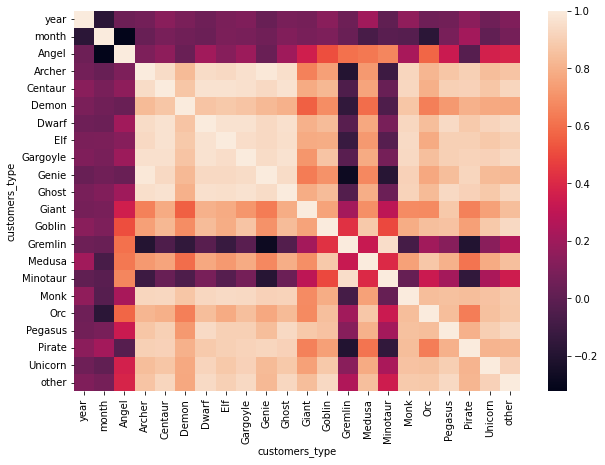

In [9]:
"""
Структурирую данные по продажам
1. Нужно получить дату, с ней потом легче работать. Ставлю первое число соответствующего месяца
2. Делаю пивот, чтобы знать сколько людей каждой категории было в каждом городе в каждый период
3. Смотрим корреляцию между покупателями.
"""
df_client = df_client_raw.copy()
df_client['date'] = pd.to_datetime({'year':df_client.year,
                                  'month':df_client.month,
                                  'day':1})

df_client_pivot = df_client.pivot(index=['date','year', 'month','ira'], 
                                  columns='customers_type', 
                                  values='amount_of_customers').reset_index()

corr = df_client_pivot.corr()
fig, ax = plt.subplots(1, figsize=(10,7))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
print(
"""
В целом есть несколько групп покупателей с высокой скоррелированностью около 0.9.
На первом этапе оставим как есть, т.к. будем делать CATBOOST, а он сам справится с этим
""")
# TODO сделать PCA для покупателей, посмотреть на результат модели.
# TODO отнормировать (город, тип покупателя) покупателей для корректного расчета

In [10]:
"""
Объединяю данные по продажам и покупателям для итогового датасета
"""

df_master = df_sales.merge(df_client_pivot, on =['date','ira'])
print(df_master.describe())
print(df_master.info())

       item_per_bundle        volume       price  price_norm   volume_mean  \
count       964.000000    964.000000  964.000000  964.000000    964.000000   
mean          1.455394   4712.655602    1.744098    1.240090   4712.655602   
std           0.742622   3682.266342    0.737851    0.102661   3325.569467   
min           1.000000     54.000000    1.163406    0.955467    251.600000   
25%           1.000000   2079.000000    1.257571    1.175492   2304.818182   
50%           1.000000   3666.000000    1.298127    1.255966   3774.400000   
75%           2.000000   6195.000000    2.263105    1.291007   6456.000000   
max           3.000000  26952.000000    3.632387    1.440154  14189.366667   

        count_val   volume_std  price_finish   volume_norm         year  \
count  964.000000   964.000000    964.000000  9.640000e+02   964.000000   
mean    26.695021  1326.239264      1.293851 -7.370775e-18  2017.928423   
std      6.374952   915.556985      0.080415  9.795415e-01     0.750259 

### Build model

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5, svd_solver='full')
col_pca = ['Angel', 'Archer', 'Centaur', 'Demon', 'Dwarf',
       'Elf', 'Gargoyle', 'Genie', 'Ghost', 'Giant', 'Goblin', 'Gremlin',
       'Medusa', 'Minotaur', 'Monk', 'Orc', 'Pegasus', 'Pirate', 'Unicorn',
       'other']
x_pca = pca.fit_transform(df_master[col_pca])
df_master[['1','2','3','4','5']] =x_pca
df_master

,location,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,date,price_norm,volume_mean,count_val,volume_std,price_finish,volume_norm,year,month,Angel,Archer,Centaur,Demon,Dwarf,Elf,Gargoyle,Genie,Ghost,Giant,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other,1,2,3,4,5
0,Alpha City,AC,Chocolates,Ferrero Rocher,sku #15,1,Standart,No,Nothing,8028.0,1.221336,2017-01-01,1.221336,10253.600000,30,2967.979013,1.339017,-0.749871,2017,1,1527.0,679.0,1315.0,575.0,610.0,5882.0,1268.0,4899.0,1006.0,871.0,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0,-2651.766534,1804.816953,4929.833081,196.326876,-470.967284
1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #16,3,Standart,No,Nothing,6606.0,2.866401,2017-01-01,0.955467,6556.200000,30,1394.391658,1.138415,0.035714,2017,1,1527.0,679.0,1315.0,575.0,610.0,5882.0,1268.0,4899.0,1006.0,871.0,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0,-2651.766534,1804.816953,4929.833081,196.326876,-470.967284
2,Alpha City,AC,Chocolates,Ferrero Rocher,sku #22,2,Standart,No,Nothing,11688.0,2.093719,2017-01-01,1.046859,14189.366667,30,3914.027826,1.206118,-0.639077,2017,1,1527.0,679.0,1315.0,575.0,610.0,5882.0,1268.0,4899.0,1006.0,871.0,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0,-2651.766534,1804.816953,4929.833081,196.326876,-470.967284
3,Alpha City,AC,Chocolates,Ferrero Rocher,sku #28,3,Standart,No,Nothing,3582.0,2.866401,2017-01-01,0.955467,3254.766667,30,816.889208,1.138415,0.400585,2017,1,1527.0,679.0,1315.0,575.0,610.0,5882.0,1268.0,4899.0,1006.0,871.0,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0,-2651.766534,1804.816953,4929.833081,196.326876,-470.967284
4,Alpha City,AC,Chocolates,Ferrero Rocher,sku #30,1,Standart,No,Nothing,5964.0,1.221336,2017-01-01,1.221336,11900.866667,30,3795.794649,1.339017,-1.564064,2017,1,1527.0,679.0,1315.0,575.0,610.0,5882.0,1268.0,4899.0,1006.0,871.0,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0,-2651.766534,1804.816953,4929.833081,196.326876,-470.967284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,Moon,MN,Lollipops,Chupa Chups,sku #77,1,Round,No,Nuts,186.0,1.248669,2018-04-01,1.248669,356.400000,15,97.404019,1.368352,-1.749414,2018,4,594.0,67.0,139.0,66.0,36.0,767.0,433.0,1064.0,282.0,6.0,208.0,614.0,243.0,56.0,74.0,102.0,342.0,14363.0,1131.0,1790.0,-9426.251155,6656.420274,-1444.805176,416.044490,351.668284
960,Moon,MN,Lollipops,Chupa Chups,sku #76,1,Round,Yes,Nuts,114.0,1.254547,2018-05-01,1.254547,251.600000,15,114.010526,1.368352,-1.206906,2018,5,670.0,68.0,147.0,75.0,44.0,959.0,487.0,973.0,302.0,11.0,218.0,695.0,278.0,70.0,78.0,95.0,410.0,14195.0,1731.0,2036.0,-9474.037247,6394.606869,-1159.059213,471.538776,508.478657
961,Moon,MN,Lollipops,Chupa Chups,sku #77,1,Round,No,Nuts,282.0,1.254547,2018-05-01,1.254547,356.400000,15,97.404019,1.368352,-0.763829,2018,5,670.0,68.0,147.0,75.0,44.0,959.0,487.0,973.0,302.0,11.0,218.0,695.0,278.0,70.0,78.0,95.0,410.0,14195.0,1731.0,2036.0,-9474.037247,6394.606869,-1159.059213,471.538776,508.478657
962,Moon,MN,Chocolates,Ferrero Rocher,sku #46,1,Standart,No,Nothing,2610.0,1.176974,2018-05-01,1.176974,3196.363636,11,947.145530,1.368352,-0.619085,2018,5,670.0,68.0,147.0,75.0,44.0,959.0,487.0,973.0,302.0,11.0,218.0,695.0,278.0,70.0,78.0,95.0,410.0,14195.0,1731.0,2036.0,-9474.037247,6394.606869,-1159.059213,471.538776,508.478657


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

r2_score(y_test,preds) = 0.4849842567070778
SMAPE = 4.02 %


<AxesSubplot:xlabel='pred', ylabel='volume_norm'>

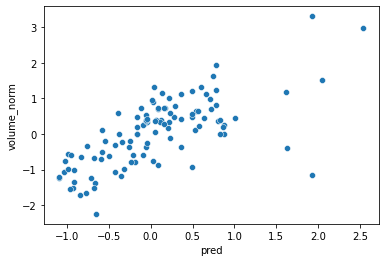

In [12]:
"""
Собираю модель. В целом из коробки Catboost хорошо работает. Руками поиграл с параметрами
"""
# фиксируем переменные для обучения
col = ['Angel', 'Archer', 'Centaur', 'Demon', 'Dwarf',
       'Elf', 'Gargoyle', 'Genie', 'Ghost', 'Giant', 'Goblin', 'Gremlin',
       'Medusa', 'Minotaur', 'Monk', 'Orc', 'Pegasus', 'Pirate', 'Unicorn',
       'other', 'price_norm']
cat_features = ['month', 'brand', 'with_alcohol', 'shape', 'filling', 'item_per_bundle']
X_res = df_master[df_master.ira == 'AC'].copy().dropna()
X = X_res[col + cat_features]
y = X_res.volume_norm
X_train, X_test, y_train, y_test, X_res_train, X_res_test = train_test_split(X, y, X_res, test_size=0.25, random_state=42)

model = CatBoostRegressor(iterations=500,
                          learning_rate=0.02,
                          l2_leaf_reg=0.001,
                          depth=5,
                         cat_features=cat_features)
model.fit(X_train, 
          y_train, 
          cat_features,
          eval_set = Pool(X_test, y_test,cat_features= cat_features),
          plot=True,
          verbose=False,
          use_best_model=True,
          early_stopping_rounds=150)

preds = model.predict(X_test)

print(f'{r2_score(y_test,preds) = }')

# restore predict and ground truth for evaluate error
X_res_test['pred'] = preds
X_res_test['pred_vol'] = X_res_test.pred * X_res_test.volume_std + X_res_test.volume_mean # Востонавливаю продажи

# Считаю метрику по заданию
smape = ((X_res_test['pred_vol'] - X_res_test['volume']).abs() / 
        (X_res_test['pred_vol'].abs() + X_res_test['volume'].abs()) / 2).mean()
print(f'SMAPE = {round(100 * smape, 2)} %')

sns.scatterplot(x=X_res_test['pred'], y=y_test)

# TODO При увеличении полноты данных необходимо сделать полноценно валидацию, подбор параметров и тест.


Из графика видно, что прайс обладает высокой значимостью на продажи
В целом, месяц объясняет основное изменение цены, которое вызвано сезонностью.
Затем внутри сезонной вариации выделяются остальные признаки. 
Их общее соотношение укладывается в ожидаемые значения.



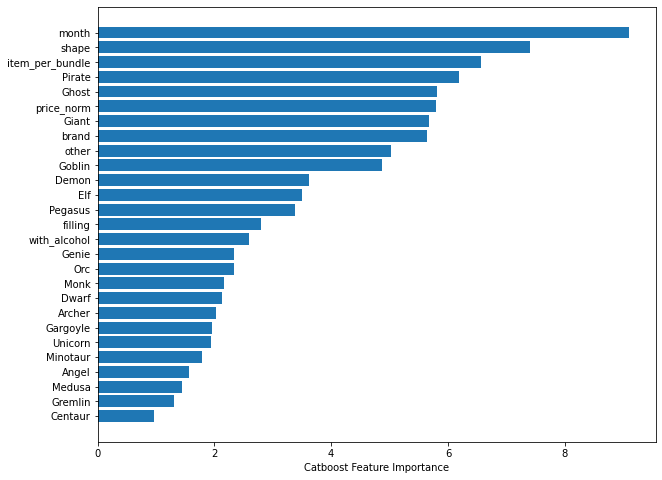

In [13]:
# show feature importances
sorted_idx = model.feature_importances_.argsort()

plt.figure(figsize=(10,8))
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Catboost Feature Importance")
print(
"""
Из графика видно, что прайс обладает высокой значимостью на продажи
В целом, месяц объясняет основное изменение цены, которое вызвано сезонностью.
Затем внутри сезонной вариации выделяются остальные признаки. 
Их общее соотношение укладывается в ожидаемые значения.
""")

In [14]:
# save model

with open('../model/model_regr.pkl', 'wb') as f:
    pickle.dump(model, f)

### Predict volume

In [15]:
# read model from file
if 'model' not in locals():
    with open('../model/model_regr.pkl', 'rb') as f:
        model = pickle.load(f)
        print('Model has loaded')
else:
    print('Model exists')

Model exists


In [16]:
# create dateset for predict

df_client_predict = df_client_pivot[df_client_pivot.date > FINISH_DATE].copy()

# collect some fetures
df_features = df_sales.groupby('sku_id', as_index=False). \
                       first()[['sku_id','product_category', 'brand', 'item_per_bundle', 'shape', 'with_alcohol', 'filling']] 

df_client_predict = df_client_predict.merge(price_end, on='ira'). \
                                      merge(df_features, on='sku_id')

df_client_predict['price_norm'] = df_client_predict['price_finish']

# predict volume_norm
df_client_predict['pred'] = model.predict(df_client_predict[col + cat_features])

# restore predict volume
df_client_predict = df_client_predict.merge(df_mean_sales, on=['sku_id', 'ira']).\
                                    merge(df_std_sales, on=['sku_id', 'ira'])


df_client_predict['pred_volume'] = (df_client_predict.pred * 
                                    df_client_predict.volume_std + 
                                    df_client_predict.volume_mean) # Востонавливаю продажи

In [17]:
# export predict to tsv
df_client_predict[['date', 'year','month','ira', 'sku_id', 'pred_volume']]. \
                sort_values(['ira','sku_id', 'month']). \
                to_csv(r'..\result\pred_volume.tsv', sep='\t')

# для удобства анализа маркетинга также делаю эксель
df_client_predict[['date', 'year','month','ira', 'sku_id', 'pred_volume']]. \
                sort_values(['ira','sku_id', 'month']). \
                to_excel(r'..\result\pred_volume.xlsx', sheet_name='Predict')

### Discount analisis

In [18]:
"""
В целом количество данных недостаточное, для того, чтобы сделать верные предложения по 
вариации цена для каждого товара.
На этом этапе предлагаю остановиться на вариации цены бренда и оптимальную продажу
Для этого создаем датасет с вариацией цены и для каждого бренда считаем выручку.
При этом помним, что часть позиций продается набором (восстанавливам цену).
"""
df_set = []
for discount in tqdm(np.arange(0.85,1.16,0.01)):
    stack = df_client_predict.copy()
    stack['price_norm'] = discount * stack['price_finish'] 
    stack['discount'] = discount
    df_set += [stack]
df_price_var = pd.concat(df_set)

100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1279.46it/s]


In [19]:
# predict volume_norm
df_price_var['pred'] = model.predict(df_price_var[col + cat_features])

# restore predict volume

df_price_var['pred_volume'] = (df_price_var.pred * 
                                    df_price_var.volume_std + 
                                    df_price_var.volume_mean) # Востонавливаю продажи

In [20]:
"""
Теперь для каждого бренда нужно выбрать оптимальную цену
Для этого рассчитываем профит и определяем максимум в группе.
"""

df_price_var['profit'] = (df_price_var['pred_volume'] *
                         df_price_var['price_norm'] * 
                         df_price_var['item_per_bundle'])


df_profit_max = df_price_var.groupby(['brand','date','discount'], as_index=False). \
                            agg({'profit':'sum'}).\
                            sort_values('profit',ascending=False). \
                            groupby(['brand', 'date',], as_index=False). \
                            agg({'profit':'first', 'discount':'first'})

print(df_profit_max)
print(
"""
В результате увеличение цены приводит к монотонному росту выручки. Возможно это связано с устойчивым (повышнным) 
спросом в летний период, который наблюдается на графиках продаж по месяцам.
Таким образом, в летний период есть возможность увеличить цены на продукцию.
""")

            brand       date         profit  discount
0     Chupa Chups 2019-07-01   18608.040337      1.15
1     Chupa Chups 2019-08-01   18881.037557      1.15
2     Chupa Chups 2019-09-01   17353.239956      1.15
3  Ferrero Rocher 2019-07-01  386689.053215      1.15
4  Ferrero Rocher 2019-08-01  362551.907322      1.15
5  Ferrero Rocher 2019-09-01  355943.288718      1.15
6       Toblerone 2019-07-01   31666.539988      1.15
7       Toblerone 2019-08-01   29458.956482      1.15
8       Toblerone 2019-09-01   28399.252960      1.15

В результате увеличение цены приводит к монотонному росту выручки. Возможно это связано с устойчивым (повышнным) 
спросом в летний период, который наблюдается на графиках продаж по месяцам.
Таким образом, в летний период есть возможность увеличить цены на продукцию.



# Summary


1. Были проанализированы продажи товаров в разных городах. 
    Построена модель предсказания продаж. 
    На отложенной тестовой выборке точность по метрике SMAPE = 4,02%.

2. На основе полученной модели были сделаны предсказания продаж на три месяца вперед.
    Результат находится в папке result.

3. Анализ влияния цены на продажи показал, что изменение цены не приводит к значительному изменению продаж.
    Возможно это связано с повышенным спросов в летний переиод.
    В результате при увеличение цены для каждого бренда приведёт к увеличению получаемой выручки.

Что можно еще сделать...

Собирая модули TODO можно дополнительно сделать.

1. В целом накблюдается недосаточное количество данных для большого количества товаров. Необходимо увеличить данные как за представленные года, так и сделать агрегацию продаж по декадам месяца. Это позволит более корректно учесть сезонность (fbprophet) и влияние цены. Сейчас влияние цены оказалось достаточно низким в предсказании.
2. Увеличение данных также позволит разбить товары на группы с низкой и высокой сезонностью,что в целом благоприятно скажется на соответствующие модели.
3. Увеличение данных также позволит корректно построить модель. Сделать полноценый подбор параметров по валидационной выборке и оценить ошибку модели на отложенной тестовой выборке.
4. Проблему с высокой скоррелированностью групп покупателей можно решить с помощью PCA. Однако введение дополнительного гиперпараметра сейчас затруднительно из-за нехватки данных.
5. Поскольку для предсказания делали стандартизацию продаж, уместно подобную стандартизацию сделать и для покупателей для построения более надежных зависимостей.
